In [1]:
from bayes_sensor import *
from requests import get, post
import json
from pprint import PrettyPrinter
from config import VALID_CONFIG
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint
DEFAULT_PROBABILITY_THRESHOLD = 0.5

def print_json(json_data):
    PrettyPrinter().pprint(json_data)

I wish to describe how the bayesian_sensor operates, lets do an investigation

### Code references
* https://github.com/home-assistant/home-assistant/blob/dev/homeassistant/components/binary_sensor/bayesian.py code
* https://home-assistant.io/components/binary_sensor.bayesian/ docs
* https://github.com/jlmcgehee21/smart_hass#binary-bayes-introspection HA sensor author script for working with bayes sensor  
* https://github.com/home-assistant/home-assistant/tree/a1f238816b6130aee2ac88fe9da54ba8f65225f3 Very early home-assistant commit to better understand HA architechture


### Bayes references
* https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/02-Discrete-Bayes.ipynb Recommended reading
* https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers another good book
* https://en.wikipedia.org/wiki/Bayes%27_theorem wikipedia on Bayes theorem
* https://en.wikipedia.org/wiki/Bayesian_inference wikipedia on Bayesian inference

### The Bayesian sensor

So you've heard about the [bayesian sensor](https://home-assistant.io/components/binary_sensor.bayesian/) in home-assistant, and would like to know what it's good for and how to use it. The Bayesian sensor (named for [Thomas Bayes](https://en.wikipedia.org/wiki/Thomas_Bayes)) should be used when you want a sensor which indicates the state of a system that you cannot directly measure. Lets consider a hypothetical scenario where want a sensor that indicates whether or not someone is cooking in the kitchen. We will call the sensor **sensor.cooking** and when someone is cooking the state is ON, otherwise the state is OFF. To be consistent with the wikipedia article on [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) lets refer to the state ON as 'event $A$' and the state OFF as 'event $\neg A$' where the $\neg$ symbol indicates 'not' $A$. I estimate that roughly 10% of the time someone is cooking, so if your were to enter the kitchen at a random time the probability ($P$) that you would find someone cooking (event $A$) is $P(A)$ = 0.1. Clearly I can then state that 90% of the time nobody will be cooking, and $P(\neg A) = 1 - P(A)$ = 0.9. We can represent this probability distribution graphically:

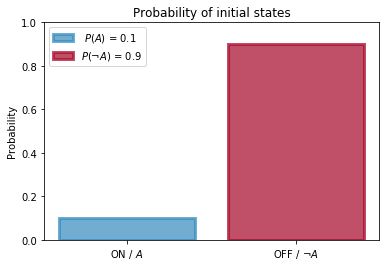

In [2]:
colours = ["#348ABD", "#A60628"]
_width=0.2
prior = 0.1
x = [0.25, 0.5]
y = [prior, 1 - prior]

plt.bar(x[0], y[0], alpha=0.7,
        width=_width, color=colours[0],
        label= " $P(A)$ = " + str(prior),
        lw="3", edgecolor=colours[0])

plt.bar(x[1], y[1], alpha=0.7,
        width=_width, color=colours[1],
        label= r"$P(\neg A)$ = " + str(1 - prior),
        lw="3", edgecolor=colours[1])

plt.ylim(0,1)
plt.xticks(x, ["ON / $A$", r"OFF / $\neg A$"])
plt.title("Probability of initial states")
plt.ylabel("Probability")
plt.legend(loc="upper left");

Lets say that I create **sensor.cooking** at a random time with no knowledge about whether someone is cooking at the time. My initial belief about the likelihood that someone is cooking ($P(A)$) is reffered to as the *prior*, as it is my belief prior to any measurement. We have previously established that the prior, $P(A)$ = 0.1. Lets say that I have built a DIY sensor for detecting cooking smells and through experimentation I have concluded that it measures a true-positive ON 70% of the time when someone is cooking. I call the ON state of this DIY sensor 'event $B$' and can now state the likelihood that this sensor is ON *given* that someone is cooking is 70%. In algebraic notation, *given* is represented by the $|$ symbol and I can now state that the likelihood $P(A|B)$ = 0.7. However this DIY sensor is not perfect and measures a false-positive ON 10% of the time. We capture this false-positive likelihood in the expression $P(B| \neg A)$ = 0.1. 

It turns out that we now have enough information to calculate the probability that we really care about, $P(A|B)$ which is the probability that someone is cooking *given* that we measured an ON with the DIY sensor. This probability is referred to as the *posterior* probability, as is is calculated after (or posterior to) the measurement. The posterior is calculated using the Bayes formula, where in words:

$$\mathtt{posterior} = \frac{\mathtt{likelihood} \times \mathtt{prior}}{\mathtt{normalisation}}$$ 

The [full algebraic expression](https://en.wikipedia.org/wiki/Bayes%27_theorem) is:

$$P(A|B) = \frac{P(B|A)\,P(A)}{ P(B|A) P(A) + P(B| \neg A) P(\neg A)}\cdot$$

Bayes formula is implemented in the Home-assistant [bayesian_sensor](https://home-assistant.io/components/binary_sensor.bayesian/) in the function update_probability():

In [3]:
def update_probability(prior, prob_true, prob_false):
    """Update probability using Bayes' rule."""
    numerator = prob_true * prior
    denominator = numerator + prob_false * (1 - prior)
    probability = numerator / denominator
    return probability

For bayesian sensors we typically define a cutoff probability of 50% ($P$ = 0.5), below which we consider the sensor to be OFF, and obove which the sensor is ON. Before any measurements we only have our prior to estimate the state of the sensor, and since our prior is below the cutoff (0.1 < 0.5) the initial state of **sensor.cooking** is OFF. 


Lets now imagine we've made a single measurement using the DIY sensor and its state is ON. We know that for a single reading the likelihood $P(B|A)$ = 0.7. To use the same variable names as update_probability(), our complete set of inputs are; the prior $P(A)$ = 0.1, the true positive likelihood prob_true = $P(B|A)$ = 0.7, and the false positive likelihood prob_false = $P(B| \neg A)$ = 0.1. Lets plug these into update_probability() (which is Bayes formula) and calculate the posterior probability ($P(A|B)$):

In [4]:
prior = 0.1
prob_true = 0.7
prob_false = 0.1
posterior = update_probability(prior, prob_true, prob_false)
print(round(posterior,2))

0.44


We find that after a single reading the posterior is below the 50% threshold and **sensor.cooking** remains OFF. 
However the posterior probability of 0.44 now becomes the prior for the next measurement. Lets say that we have a second sensor we believe detects cooking but with a much lower true positive rate, that is also reads ON, how does this improve the posterior probability? We calculate:

In [5]:
prior = 0.44
prob_true = 0.15
prob_false = 0.1
posterior = update_probability(prior, prob_true, prob_false)
print(round(posterior,2))

0.54


And great news, with only two measurements the posterior probability is above the 50% threshold and **sensor.cooking** is now ON. 

Lets now consider a second hypothetical scenarior, and ask how many of the poor sensors does it require to trigger **sensor.cooking** to ON?

In [6]:
prior = 0.1
prob_true = 0.2
prob_false = 0.1
posterior = prior # Our initial conditions
while posterior < 0.5:
    posterior = update_probability(posterior, prob_true, prob_false)
    print(posterior)

0.18181818181818182
0.3076923076923077
0.47058823529411764
0.64


We find that four consecutive ON measurements are required to trigger **sensor.cooking** to ON.

Now, how do we update our posterior if we receive a negative reading?

How about combining the readings from several sensors?

## Bayesian sensor

The component works by creating a list of all the sensors in the config that are in their ON state, and calculatules the conditional probability based on their prob_true/prob_false values. Lets check that by creating a Change bayesian sensor on a localhost HA instance and query it via the restfulAPI. I will start by creating the bayesian sensor example from the [docs](https://home-assistant.io/components/binary_sensor.bayesian/), with a couple of dummy switches as inputs.

```
switch:
  platform: command_line
  switches:
    kitchen_lights:
      command_on: ""
      command_off: ""
    bedroom_lights:
      command_on: ""
      command_off: ""

binary_sensor:
  - platform: bayesian
    prior: 0.1
    observations:
      - entity_id: 'switch.kitchen_lights'
        prob_given_true: 0.6
        prob_given_false: 0.2
        platform: 'state'
        to_state: 'on'
      - entity_id: 'switch.bedroom_lights'
        prob_given_true: 0.25
        prob_given_false: 0.1
        platform: 'state'
        to_state: 'on'
```

Initially, the switches are off

In [7]:
url = 'http://localhost:8123/api/states/switch.kitchen_lights'
headers = {'content-type': 'application/json'}

response = get(url, headers=headers).json()
print_json(response['state'])

'off'


In [8]:
url = 'http://localhost:8123/api/states/switch.bedroom_lights'
headers = {'content-type': 'application/json'}

response = get(url, headers=headers).json()
print_json(response['state'])

'off'


Lets switch on switch.kitchen_lights and see how the binary_sensor behaves

In [9]:
url = 'http://localhost:8123/api/services/switch/turn_on'
payload = {'entity_id': 'switch.kitchen_lights'}
headers = {'content-type': 'application/json'}

response = post(url, data=json.dumps(payload), headers=headers).json()
print_json(response)

[{'attributes': {'friendly_name': 'BayesianBinary',
                 'observations': [{'prob_false': 0.2, 'prob_true': 0.6}],
                 'probability': 0.25,
                 'probability_threshold': 0.5},
  'entity_id': 'binary_sensor.bayesianbinary',
  'last_changed': '2017-12-15T06:48:29.173741+00:00',
  'last_updated': '2017-12-15T06:48:39.547470+00:00',
  'state': 'off'},
 {'attributes': {'assumed_state': True, 'friendly_name': 'kitchen_lights'},
  'entity_id': 'switch.kitchen_lights',
  'last_changed': '2017-12-15T06:48:39.546260+00:00',
  'last_updated': '2017-12-15T06:48:39.546260+00:00',
  'state': 'on'},
 {'attributes': {'assumed_state': True,
                 'auto': True,
                 'entity_id': ['switch.bedroom_lights',
                               'switch.kitchen_lights'],
                 'friendly_name': 'all switches',
                 'hidden': True,
                 'order': 0},
  'entity_id': 'group.all_switches',
  'last_changed': '2017-12-15T06:48:39

In [10]:
response[0]['attributes']['probability']

0.25

We can see that the bayesian sensor has been updated to include the observations associated with switch.kitchen_lights and the probability has been updated to 0.25. Lets just check that this agrees with what we expect.

In [11]:
prior = 0.1
prob_true = 0.6
prob_false = 0.2
posterior = update_probability(prior, prob_true, prob_false)
print(round(posterior,2))

0.25


Now lets turn on the second switch.

In [12]:
url = 'http://localhost:8123/api/services/switch/turn_on'
payload = {'entity_id': 'switch.bedroom_lights'}
headers = {'content-type': 'application/json'}

response = post(url, data=json.dumps(payload), headers=headers).json()
print_json(response)

[{'attributes': {'friendly_name': 'BayesianBinary',
                 'observations': [{'prob_false': 0.2, 'prob_true': 0.6},
                                  {'prob_false': 0.1, 'prob_true': 0.25}],
                 'probability': 0.45,
                 'probability_threshold': 0.5},
  'entity_id': 'binary_sensor.bayesianbinary',
  'last_changed': '2017-12-15T06:48:29.173741+00:00',
  'last_updated': '2017-12-15T06:48:39.737947+00:00',
  'state': 'off'},
 {'attributes': {'assumed_state': True, 'friendly_name': 'bedroom_lights'},
  'entity_id': 'switch.bedroom_lights',
  'last_changed': '2017-12-15T06:48:39.736376+00:00',
  'last_updated': '2017-12-15T06:48:39.736376+00:00',
  'state': 'on'}]


In [13]:
response[0]['attributes']['probability']

0.45

We can see that the bayesian sensor has again been updated to include the observations associated with switch.bedroom_lights and the probability has been updated to 0.45. Lets just check that this agrees with what we expect.

In [14]:
prior = 0.25
prob_true = 0.25
prob_false = 0.1
posterior = update_probability(prior, prob_true, prob_false)
print(round(posterior,2))

0.45


Fantastic, it agrees, however note that the probability of 0.45 is below the standard threshold of 0.5. Lets switch off lights.

In [15]:
url = 'http://localhost:8123/api/services/switch/turn_off'

response = post(url).json()
print_json(response)

[{'attributes': {'friendly_name': 'BayesianBinary',
                 'observations': [],
                 'probability': 0.1,
                 'probability_threshold': 0.5},
  'entity_id': 'binary_sensor.bayesianbinary',
  'last_changed': '2017-12-15T06:48:29.173741+00:00',
  'last_updated': '2017-12-15T06:48:39.918076+00:00',
  'state': 'off'},
 {'attributes': {'assumed_state': True, 'friendly_name': 'bedroom_lights'},
  'entity_id': 'switch.bedroom_lights',
  'last_changed': '2017-12-15T06:48:39.907083+00:00',
  'last_updated': '2017-12-15T06:48:39.907083+00:00',
  'state': 'off'},
 {'attributes': {'assumed_state': True, 'friendly_name': 'kitchen_lights'},
  'entity_id': 'switch.kitchen_lights',
  'last_changed': '2017-12-15T06:48:39.916704+00:00',
  'last_updated': '2017-12-15T06:48:39.916704+00:00',
  'state': 'off'},
 {'attributes': {'assumed_state': True,
                 'auto': True,
                 'entity_id': ['switch.bedroom_lights',
                               'switch.

In [16]:
response[0]['attributes']['probability']

0.1

And we are back to our original prior.

What is clear from this exercise is that if you don't choose your input sensors/switches, weights and thresholds correctly, the bayesian sensor is pretty useless as it is never on. In practice the best approach is to set your inputs and their weights with your best guess, then monitor the probability of the bayesian_sensor for a few days and note its value at the times you care about (e.g. whilst cooking), then set your default threshold at this level. For example, in our scenario we observed that the probaility 0.45 < 0.5, so we would then set our default threshold to 0.44.

Another thing that is pretty clear from this exercise if that if you only have a couple of inputs (say less than three or four), then there isn't much point in using a bayesian_sensor over a regular group. The bayesian_sensor only shows its value when you have many inputs, combining both weakly and strongly sensitivie/specific sensors. In such a case you could write many rules to determine when to trigger a group sensor, but the bayes_sensor takes care of the calculation for you. 

If you find that you have relatively few inputs corresponding to real sensors/switches, one strategy to implement a bayesian_sensor is to create software sensors which trigger after given time delay after a state change. For example, in the cooking scenario, I might consider creating a sensor which triggers ON only when there has been motion activity for more than 5 minutes in the kitchen. You could use the [timer](https://home-assistant.io/components/timer/) component and automations to create your software sensor.